<img src='images/Northwind_ERD_updated.png.'>

# Question

### Which region is preforming the best?

[Explaination goes here]

# Hypothesis for Z-Test

### H0: no effect - Item total for specific regions is no different than that of all regions

### HA: effect - Item total for specific regions is different than that of all regions

The bolded items in the H0 statement represent the data that needs to be pulled down from the database. 

### Feature: RegionId
### Target: OrderDetail.Quantity * OrderDetail.UnitPrice

# Gathering data

### Importing the data

In [2]:
import pandas as pd
import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import scipy.stats as stats
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Setting up the connection with the database

In [3]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

### Looking at the necessary data

In [36]:
cur.execute("""SELECT *
               FROM Territory
               """)
territory = pd.DataFrame(cur.fetchall())
territory.columns = [x[0] for x in cur.description]
territory.head()

,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


In [46]:
cur.execute("""SELECT *
               FROM EmployeeTerritory
               """)
employeeTerritory = pd.DataFrame(cur.fetchall())
employeeTerritory.columns = [x[0] for x in cur.description]
employeeTerritory.head()

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


In [20]:
cur.execute("""SELECT *
               FROM Employee
               """)
employee = pd.DataFrame(cur.fetchall())
employee.columns = [x[0] for x in cur.description]
employee.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


In [24]:
cur.execute("""SELECT *
               FROM 'Order'
               """)
order = pd.DataFrame(cur.fetchall())
order.columns = [x[0] for x in cur.description]
order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [27]:
cur.execute("""SELECT *
               FROM OrderDetail
               """)
orderDetail = pd.DataFrame(cur.fetchall())
orderDetail.columns = [x[0] for x in cur.description]
orderDetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [78]:
cur.execute("""SELECT Territory.Id as TerritoryId, RegionId, EmployeeTerritory.EmployeeId, Employee.Region, 'Order'.Id, UnitPrice*Quantity as ItemTotal
               FROM Territory
               LEFT JOIN EmployeeTerritory ON Territory.Id = EmployeeTerritory.TerritoryId
               JOIN Employee on EmployeeTerritory.EmployeeId = Employee.Id
               JOIN 'Order' on Employee.Id = 'Order'.EmployeeId
               JOIN OrderDetail on 'Order'.Id = OrderDetail.OrderId
               """)
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df

,TerritoryId,RegionId,EmployeeId,Region,Id,ItemTotal
0,02903,1,5,British Isles,10248,168.0
1,07960,1,5,British Isles,10248,168.0
2,08837,1,5,British Isles,10248,168.0
3,10019,1,5,British Isles,10248,168.0
4,10038,1,5,British Isles,10248,168.0
...,...,...,...,...,...,...
10124,19713,1,1,North America,11077,30.0
10125,06897,1,1,North America,11077,31.0
10126,19713,1,1,North America,11077,31.0
10127,06897,1,1,North America,11077,26.0


# Scrub Data

The following scrubbing techniques were applied to the original data:
- Manage n/a data types
- Delete duplicate rows
- Correct data types
- Find outliers

### Manage n/a data types

In [79]:
# nans identification
print(len(df))
df.isna().sum()

10129


TerritoryId    0
RegionId       0
EmployeeId     0
Region         0
Id             0
ItemTotal      0
dtype: int64

### Delete duplicate data

In [80]:
# identification of duplicate data
print('duplicated rows: ' + str(df.duplicated().sum()))

duplicated rows: 14


In [81]:
# code to drop duplicate row if necessary
df.drop_duplicates(inplace=True)
print('duplicated rows: ' + str(df.duplicated().sum()))

duplicated rows: 0


### Correct data types

First, let's see what the data types for this data set are.

In [82]:
# data type identification
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10115 entries, 0 to 10128
Data columns (total 6 columns):
TerritoryId    10115 non-null object
RegionId       10115 non-null int64
EmployeeId     10115 non-null int64
Region         10115 non-null object
Id             10115 non-null int64
ItemTotal      10115 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 553.2+ KB


In [83]:
df.TerritoryId.unique()

array(['02903', '07960', '08837', '10019', '10038', '11747', '14450',
       '85014', '85251', '98004', '98052', '98104', '20852', '27403',
       '27511', '30346', '31406', '32859', '33607', '03049', '03801',
       '48075', '48084', '48304', '55113', '55439', '06897', '19713',
       '19428', '44122', '45839', '53404', '01581', '01730', '01833',
       '02116', '02139', '02184', '40222', '60179', '60601', '80202',
       '80909', '90405', '94025', '94105', '95008', '95054', '95060'],
      dtype=object)

In [84]:
df['TerritoryId'] = df['TerritoryId'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10115 entries, 0 to 10128
Data columns (total 6 columns):
TerritoryId    10115 non-null int32
RegionId       10115 non-null int64
EmployeeId     10115 non-null int64
Region         10115 non-null object
Id             10115 non-null int64
ItemTotal      10115 non-null float64
dtypes: float64(1), int32(1), int64(3), object(1)
memory usage: 513.7+ KB


In [85]:
df.Region.unique()

array(['British Isles', 'North America'], dtype=object)

In [86]:
df['Region'] = ['British_Isles' if x == 'British Isles' else 'North_America' for x in df['Region']]

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10115 entries, 0 to 10128
Data columns (total 6 columns):
TerritoryId    10115 non-null int32
RegionId       10115 non-null int64
EmployeeId     10115 non-null int64
Region         10115 non-null object
Id             10115 non-null int64
ItemTotal      10115 non-null float64
dtypes: float64(1), int32(1), int64(3), object(1)
memory usage: 513.7+ KB


In [88]:
df.Region.unique()

array(['British_Isles', 'North_America'], dtype=object)

In [92]:
df['Region'] = [str(x) for x in df['Region']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10115 entries, 0 to 10128
Data columns (total 6 columns):
TerritoryId    10115 non-null int32
RegionId       10115 non-null int64
EmployeeId     10115 non-null int64
Region         10115 non-null object
Id             10115 non-null int64
ItemTotal      10115 non-null float64
dtypes: float64(1), int32(1), int64(3), object(1)
memory usage: 513.7+ KB


In [93]:
df.columns

Index(['TerritoryId', 'RegionId', 'EmployeeId', 'Region', 'Id', 'ItemTotal'], dtype='object')

### Find outliers

In [ ]:
# outlier identification
pass

In [ ]:
# management of outliers
pass

Observations about data types

# Explore Data

For a quick preview of what we have to work with, we'll use the describe method.

In [ ]:
# describe data
df.describe()

Observations about df.describe()

### Visualize data

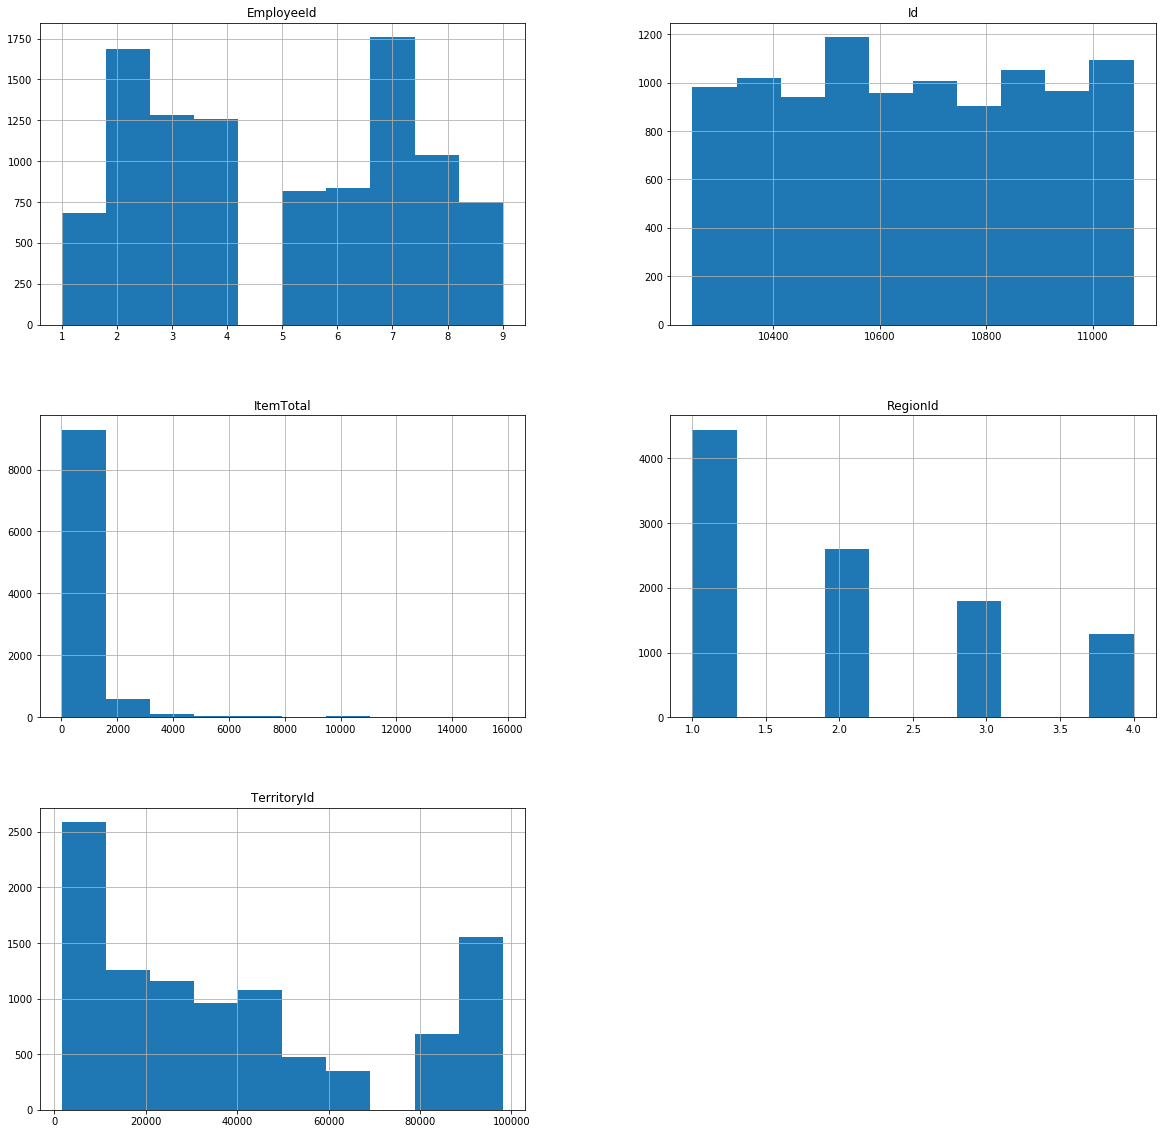

In [94]:
# visualize data
df.hist(figsize=(20,20));

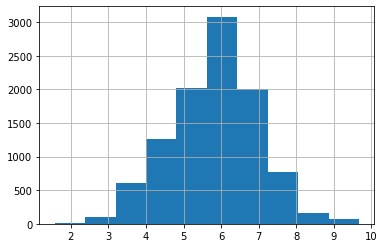

In [95]:
df['ItemTotal'] = df['ItemTotal'].map(lambda x: np.log(x))
df.ItemTotal.hist()

### Sort data

Plan and justification of sorting data

In [ ]:
# sort data
pass

Observations about sorted data

### Develop feature

In [ ]:
# create features
pass

# Model Data
Below is the model after scrubbing and exploring have been managed, let's see what the model picks up.

### Data normality

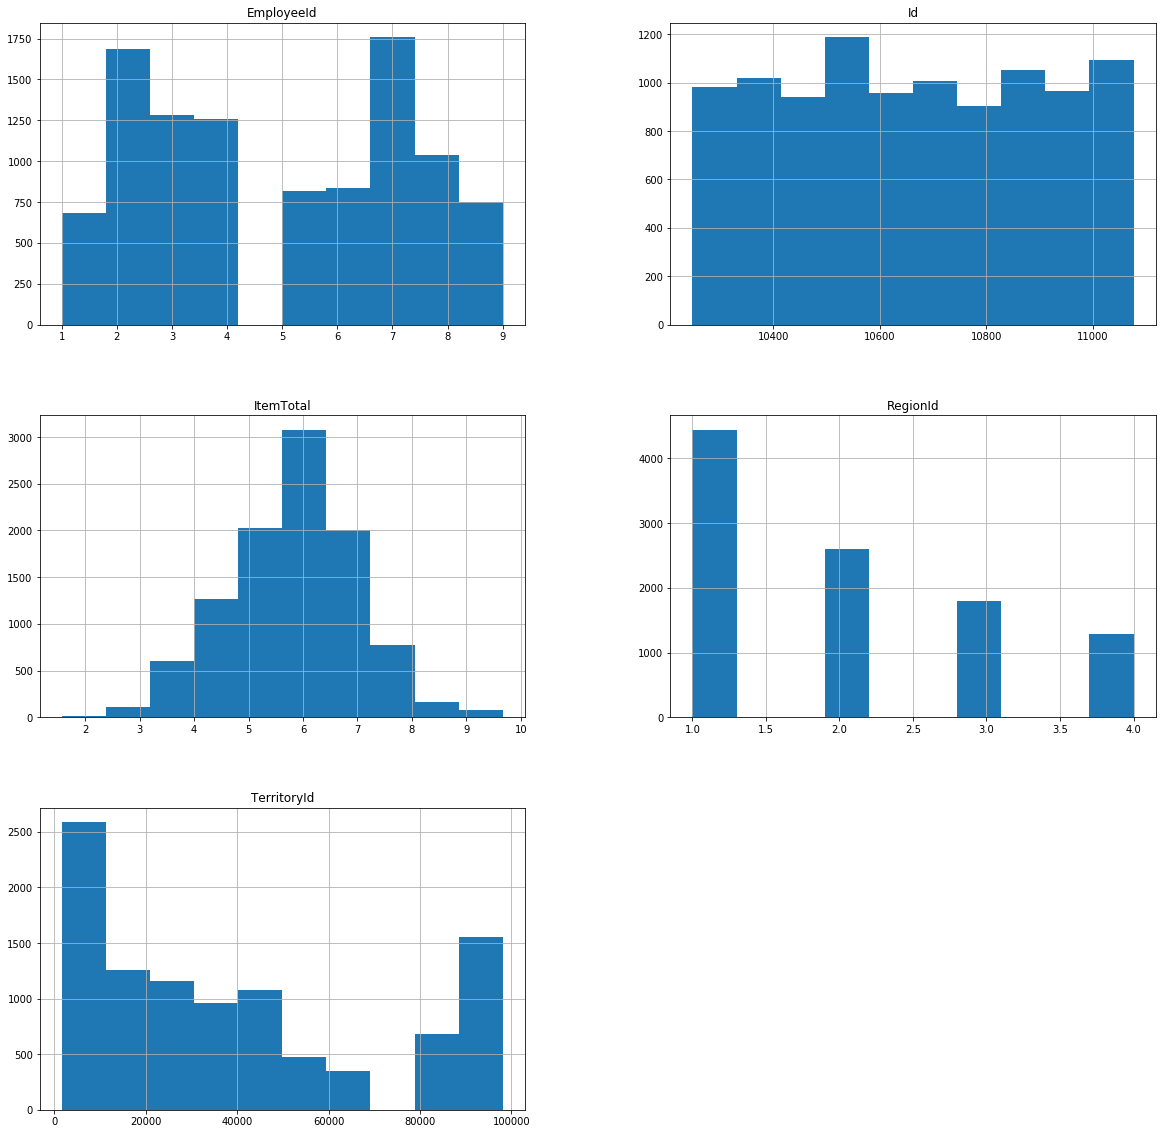

In [96]:
# visual/code for data normality
df.hist(figsize=(20,20));

### Standard deviation

In [97]:
# standard deviation for target variable
print('ItemTotal')
print('mean: ' + str(mean(df['ItemTotal'])))
print('standard deviation: ' + str(std(df['ItemTotal'])))

ItemTotal
mean: 5.823464433170018
standard deviation: 1.1651381792988267


### Setting up for testing

[Explaination of plan goes here]

In [5]:
# [name what you're doing here]
# cur.execute("""SELECT *
#                FROM
#                """)
# df_ = pd.DataFrame(cur.fetchall())
# df_.columns = [x[0] for x in cur.description]
# df_

In [6]:
# histogram for [feature]
# plt.hist()

In [7]:
# histogram for [target]
# plt.hist()

# Testing

## [Name of test goes here]

### Setting up variables

In [8]:
# calculating the [name of test here] (doing on 'paper' to confirm that the data is organized correctly before running test)
alpha = ''
pass

### [Name of test here]

In [9]:
pass

### Result

In [10]:
p_value = ''

# Evaluating the results

In [11]:
if alpha > p_value:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Fail to reject the null hypothesis


[Paragraph about the results and next steps]

# Digging Deeper

## [non-parametric test name]

In [12]:
# visualizing the data to evaluate for possible error
# sns.distplot()
# sns.distplot();

In [13]:
# [test name here]
pass

In [14]:
# result
p_value = ''

In [15]:
# evaluating the result
if alpha > p_value:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Fail to reject the null hypothesis


[paragraph about non-parametric testing]

## Effect size -- Cohen's D

In [16]:
def cohen_d_one_samp(x, mu0):
    mu = mean(x)
    sample_std = std(x, ddof=1)
    return (mu - mu0) / sample_std
def cohen_d_two_samp(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)
# effect_size = cohen_d_two_samp('', '')
# effect_size

[Comment about the effect size and what it means, then introduce the idea of power]

## Power

In [17]:
# prepping variables
# effect_size, nobs1, alpha = effect_size, ''.shape[0], alpha

In [18]:
# power test
# power = tt_ind_solve_power(effect_size=effect_size, nobs1=nobs1, alpha=alpha)
# power

In [19]:
# results
# type_2_error = 1 - power
# type_2_error

[Paragraph talking about power and next steps][The next test should explore deeper into what the data collected previously shows]

## [Next test here]

### H0: 
### HA: 

### Looking at the necessary data to [fill in a specific here]

[Note again how the data has been changed, ensure that those changes remain in place to maintain continutity between testing]

In [20]:
# visual reminder of data from beginning
# cur.execute("""SELECT 
#                FROM 
#                """)
# df_ = pd.DataFrame(cur.fetchall())
# df_.columns = [x[0] for x in cur.description]
# df_['Discount']

In [21]:
# previewing data based on experiment constraints
pass

In [22]:
# variables are prepped from the original data frame
pass

In [23]:
# [test]
pass

In [24]:
# results
p_value = ''

In [25]:
# evaluating results
if alpha > p_value:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Fail to reject the null hypothesis


[comment about results of follow up testing]

# Actionable Items and Insights

[conclusion applicable to clients]

# Useful visualizations of results

In [26]:
# visual of no differences
pass